In [1]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates

from stompy import utils
from stompy import filters
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy import xr_utils, xr_transect
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
from stompy.spatial import field, proj_utils 
from stompy.model import data_comparison
%matplotlib notebook

In [2]:
ls runs/

cfg006_20180401/         snubby_cfg003_20180322/  snubby_cfg003_20180404/
snubby_cfg003_20180310/  snubby_cfg003_20180323/  snubby_cfg003_20180405/
snubby_cfg003_20180311/  snubby_cfg003_20180324/  snubby_cfg003_20180406/
snubby_cfg003_20180312/  snubby_cfg003_20180325/  snubby_cfg003_20180407/
snubby_cfg003_20180313/  snubby_cfg003_20180326/  snubby_cfg003_20180408/
snubby_cfg003_20180314/  snubby_cfg003_20180327/  snubby_cfg003_20180409/
snubby_cfg003_20180315/  snubby_cfg003_20180328/  snubby_cfg003_20180410/
snubby_cfg003_20180316/  snubby_cfg003_20180329/  snubby_cfg003_20180411/
snubby_cfg003_20180317/  snubby_cfg003_20180330/  snubby_cfg004_20180310/
snubby_cfg003_20180318/  snubby_cfg003_20180331/  steady005_20180401/
snubby_cfg003_20180319/  snubby_cfg003_20180401/  steady007_20180401/
snubby_cfg003_20180320/  snubby_cfg003_20180402/  steady008_20180401/
snubby_cfg003_20180321/  snubby_cfg003_20180403/


In [3]:
six.moves.reload_module(sun_driver)
models=[
    #sun_driver.SuntansModel.load("runs/snubby_cfg003_20180403"),
    #sun_driver.SuntansModel.load("runs/steady005_20180401"),
    #sun_driver.SuntansModel.load("runs/cfg006_20180401"),   
    sun_driver.SuntansModel.load("runs/steady007_20180401"),
    sun_driver.SuntansModel.load("runs/steady008_20180401")
]

for m in models:
    m.projection="EPSG:26910"    
    m.label=os.path.basename(m.run_dir)

fig_dir=os.path.join(models[-1].run_dir,'figs-20190621')
os.path.exists(fig_dir) or os.makedirs(fig_dir)

True

In [5]:
obs_tran=xr.open_dataset("../../field/adcp/040518_BT/040518_5BTref-avg.nc")
obs_tran['eta']=0*obs_tran.depth_m
obs_tran.attrs['label']='2018_05'
transect=obs_tran
xr_transect.add_rozovski(transect)

In [6]:
def extract_to_match_obs(obs_tran,model):
    transect=model.extract_transect(xy=np.c_[obs_tran.x_sample,obs_tran.y_sample],
                                    dx=5,time=-1)
    offset=np.nanmean(transect.eta.values)
    transect['eta'].values[:] -= offset
    transect['dv'].values[:] += offset
    transect['z_ctr'].values[:] -= offset
    transect['depth_m']=transect.dv
    transect.attrs['label']=model.label
    xr_transect.add_rozovski(transect)
    return transect

In [7]:
def plot_uroz(tran,ax):
    xr_transect.plot_scalar(tran,tran.Uroz.sel(roz='downstream'),ax=ax)
    ax.plot(tran.d_sample, tran.eta,'k--',label='surface')
    ax.plot(tran.d_sample,-tran.depth_m,'k-',label='bed')

In [8]:
mod_trans=[extract_to_match_obs(obs_tran,model)
           for model in models]
all_trans=[obs_tran]+mod_trans

HERE
HERE


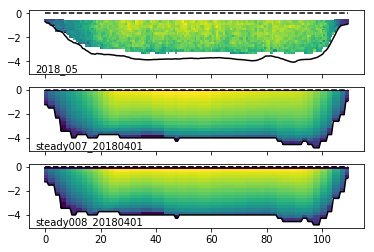

In [9]:
fig,axs=plt.subplots(len(all_trans),1,sharex=True,sharey=True)

for tran,ax in zip(all_trans,axs):
    plot_uroz(tran,ax)
    ax.text(0.02,0.04,tran.attrs['label'],transform=ax.transAxes)


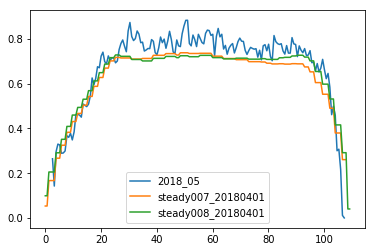

In [10]:
# Pull out velocity 1m down
new_z=np.array([-0.95,-1.05])

fig,ax=plt.subplots(1,1)

for tran in all_trans:    
    tran_slice=xr_transect.resample_z(tran,new_z,new_z_positive='up')
    Uslice=xr_transect.depth_avg(tran_slice,'Uroz')
    ax.plot(tran_slice.d_sample,Uslice.sel(roz='downstream'),label=tran.label)
ax.legend()
  

In [144]:
for tran in all_trans:
    if tran.z_ctr.attrs.get('positive','up')=='down':
        assert tran.z_ctr.mean()>0
        assert np.nanmean(np.diff(tran.z_ctr)) > 0
    else:
        assert tran.z_ctr.mean()<0
        assert np.nanmean(np.diff(tran.z_ctr))<0
    

In [142]:
tran

<xarray.Dataset>
Dimensions:           (beam: 4, layer: 145, roz: 2, sample: 170, xy: 2)
Coordinates:
  * sample            (sample) int64 0 1 2 3 4 5 6 ... 164 165 166 167 168 169
  * layer             (layer) int64 0 1 2 3 4 5 6 ... 139 140 141 142 143 144
  * beam              (beam) int64 0 1 2 3
    time              datetime64[ns] 2018-04-04
    xv                (sample) float64 6.472e+05 6.472e+05 ... 6.473e+05
    yv                (sample) float64 4.186e+06 4.186e+06 ... 4.186e+06
  * roz               (roz) <U10 'downstream' 'left'
Dimensions without coordinates: xy
Data variables:
    x_sample          (sample) float64 6.473e+05 6.473e+05 ... 6.473e+05
    y_sample          (sample) float64 4.186e+06 4.186e+06 ... 4.186e+06
    d_sample          (sample) float64 0.0 0.6455 1.291 ... 107.8 108.4 109.1
    z_ctr             (layer) float64 0.47 0.4901 0.5101 ... 3.32 3.34 3.36
    z_dz              (layer) float64 0.02007 0.02007 ... 0.02007 0.02007
    frequency         (sam